# **British Airways**  
## **Predictive Modeling of customer bookings**
---  
This jupyter notebook contains the work that I have done for the second task of the Data Science certificate offered by The Forage Work Experience with British Airways. The goal is to build a classification model that predicts whether a customer will complete the booking of a flight or not.  

### **Table of Content** 

    1. Importing Libraries and Loading the Data  
    2. Exploratory Data Analysis  
        2.1 Visualizing the data  
        2.2 Feature engineering    
            2.2.1 Route Distance  
            2.2.2 Day/Hour Transformations  
        2.3 Train_validation_test_split  
        2.4 Dealing with outliers  
        2.5 Random Undersampling  
        2.6 One-Hot encoding and standardization  
    3. Modeling 
        3.1 Logistic Regression  
        3.2 Decision Tree  
        3.3 Random Forests  
        3.4 CatBoost  
    4. Model Evaluation (CatBoost)  

## 1. Importing Libraries and Loading the Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import airportsdata
import geopy.distance
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## 2. Exploratory Data Analysis

In [6]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

We do not have any missing values.

### 2.1 Visualizing the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

There are 13 different variables (excluding the target). Among these independent variables, 8 are numerical type and 5 are object type.

In [8]:
df['wants_extra_baggage'].value_counts()

1    33439
0    16561
Name: wants_extra_baggage, dtype: int64

In [9]:
df['wants_preferred_seat'].value_counts()

0    35152
1    14848
Name: wants_preferred_seat, dtype: int64

In [10]:
df['wants_in_flight_meals'].value_counts()

0    28643
1    21357
Name: wants_in_flight_meals, dtype: int64

Some of the numerical type variables are in fact encoded binary categorical variables (wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals).

In [11]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


This summary table does not signal any anomalies or inconsistencies in the numerical data. Let's create some plots to get an idea about the distribution of the variables and their relation to the target.

[Text(0.5, 1.0, 'Booking completion')]

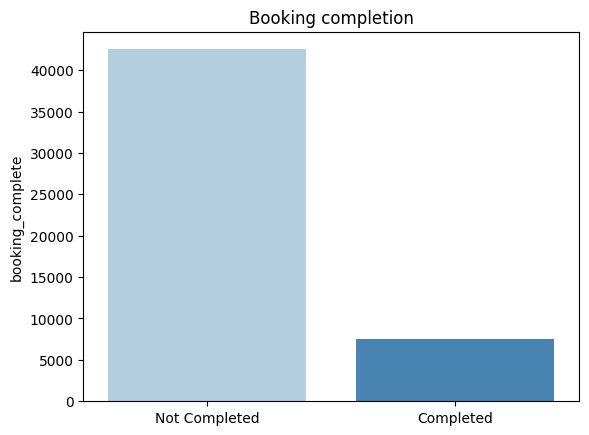

In [12]:
booking_values = df['booking_complete'].value_counts()
booking_labels = ['Not Completed', 'Completed']
sns.barplot(x = booking_labels, y = booking_values, palette = "Blues").set(title='Booking completion')

In [13]:
df['booking_complete'].value_counts(normalize=True) * 100

0    85.044
1    14.956
Name: booking_complete, dtype: float64

It seems that there is a class imbalance in our target variable. This might later compromise the performance of some models, which means that we would maybe need to fix this imbalance using resampling methods. However, the class imbalance is not extreme, we can try some models without undersampling the majority class / oversampling the minority class, but keeping in mind that we need to carefully choose the performance metric for validation and testing.

[Text(0.5, 1.0, 'Distribution of number of passengers filtered by booking completion')]

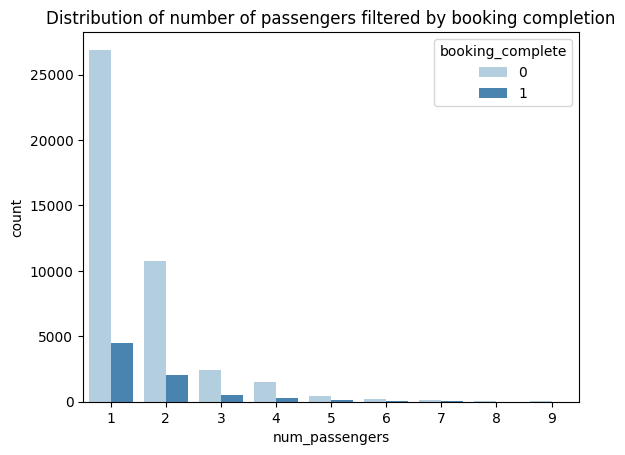

In [14]:
sns.countplot(data = df, x = 'num_passengers', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                            'Distribution of number of passengers filtered by booking completion')

[Text(0.5, 1.0, 'Distribution of number of passengers')]

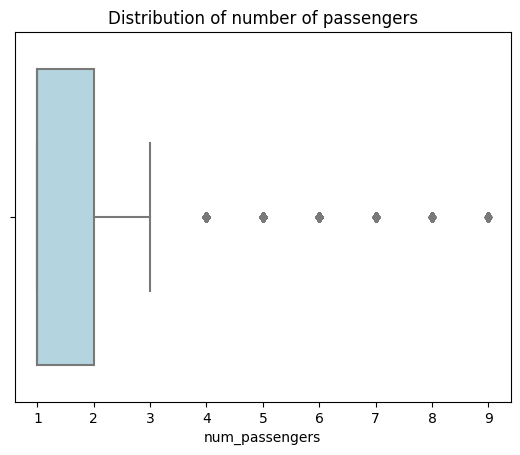

In [15]:
sns.boxplot(data = df, x = 'num_passengers', color = 'lightblue').set(title= 'Distribution of number of passengers')

It seems that this column has some outliers. All the values above the upper whisker of the boxplot will be considered as outliers. These can potentially be removed to see if the model performs better.

In [16]:
df['sales_channel'].value_counts()

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

[Text(0.5, 1.0, 'Sales channel and booking completion')]

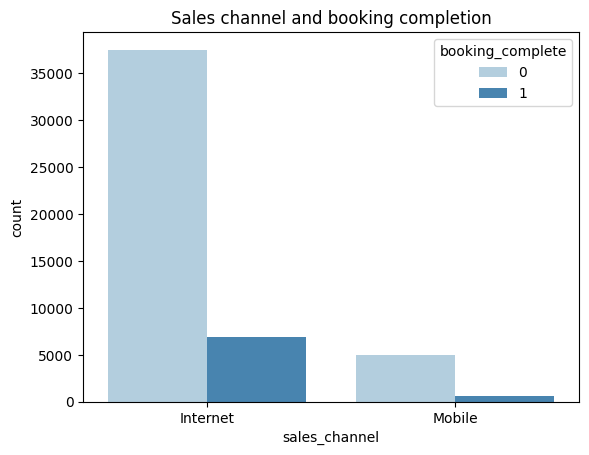

In [17]:
sns.countplot(data = df, x = 'sales_channel', hue = 'booking_complete', palette = 'Blues').set(title = 'Sales channel and booking completion')

In [18]:
df['trip_type'].value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

[Text(0.5, 1.0, 'Trip type and booking completion')]

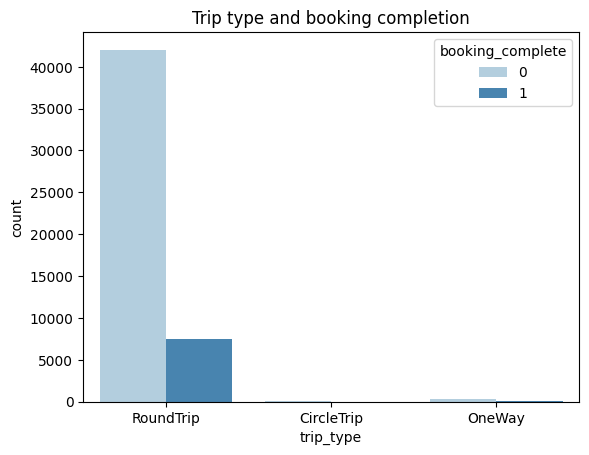

In [19]:
sns.countplot(data = df, x = 'trip_type', hue = 'booking_complete', palette = 'Blues').set(title = 'Trip type and booking completion')

Most of the trip types are round trips.

[Text(0.5, 1.0, 'Distribution of length of stay')]

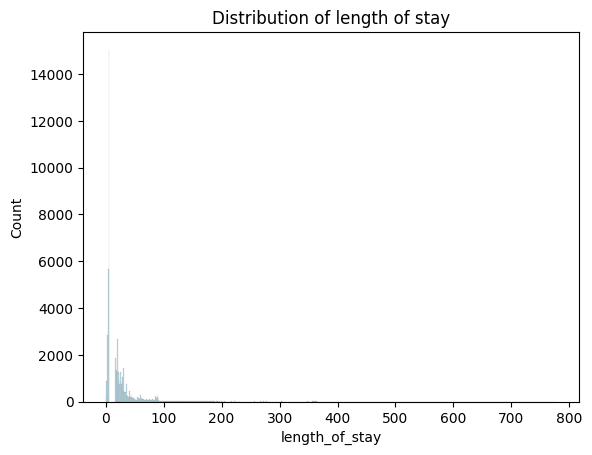

In [20]:
sns.histplot(data = df, x = 'length_of_stay', color = 'lightblue').set(title = 'Distribution of length of stay')

It seems that the length of stay variable has outliers. Let's have a look with a boxplot.

[Text(0.5, 1.0, 'Distribution of length of stay')]

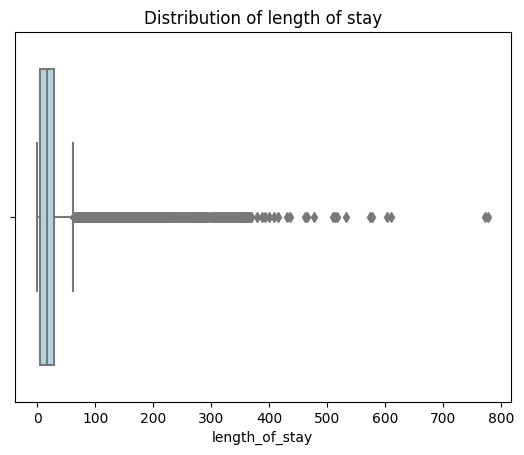

In [21]:
sns.boxplot(data = df, x = 'length_of_stay', color = 'lightblue').set(title= 'Distribution of length of stay')

We can remove these outliers to make the predictions more accurate.

[Text(0.5, 1.0, 'Distribution of flight hours filtered by booking completion')]

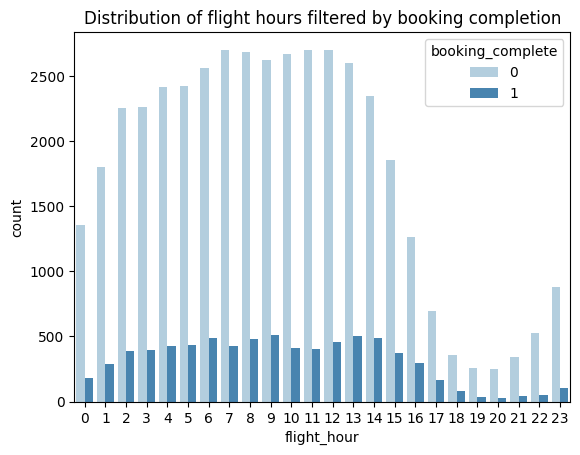

In [22]:
sns.countplot(data = df, x = 'flight_hour', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                                     'Distribution of flight hours filtered by booking completion')

[Text(0.5, 1.0, 'Distribution of flight days, filtered by booking completion')]

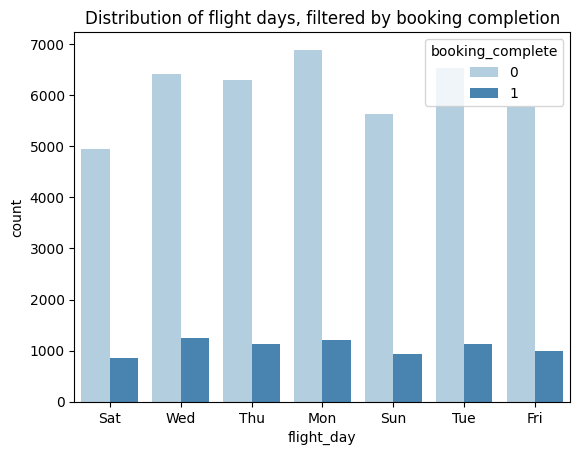

In [23]:
sns.countplot(data = df, x = 'flight_day', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                                    'Distribution of flight days, filtered by booking completion')

In [24]:
df['route'].value_counts()

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64

There are 799 different routes. What we can do is transform this column into the distances between the two airports of the route.

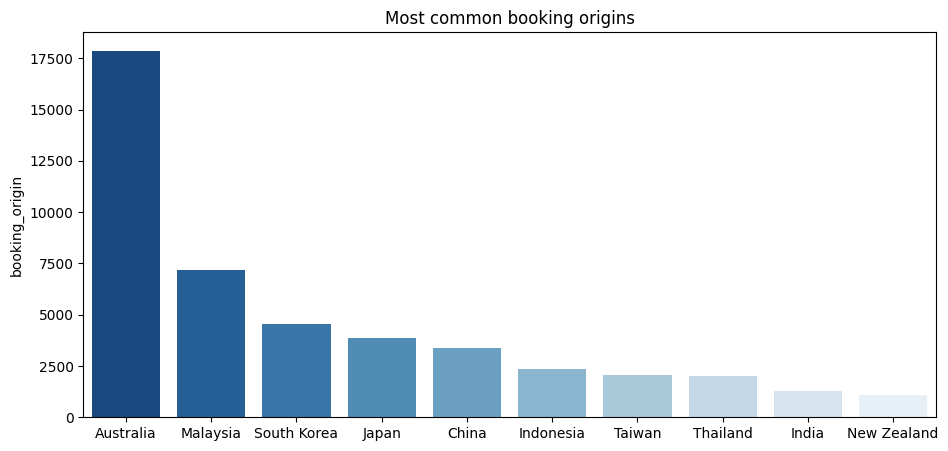

In [26]:
palette = sns.color_palette("Blues", n_colors = 10)
palette.reverse()

largest_origins = df['booking_origin'].value_counts().nlargest(10)
df_largest_origins = pd.DataFrame(largest_origins)
plt.figure(figsize=(11,5))
sns.barplot(data = df_largest_origins, x = df_largest_origins.index , y = 'booking_origin', palette = palette).set(title = 
                                                                                                    'Most common booking origins')
plt.show()

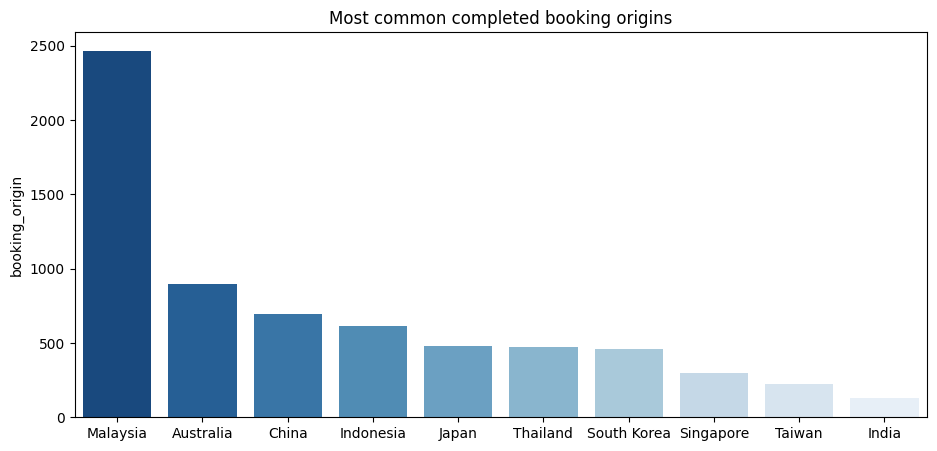

In [30]:
palette = sns.color_palette("Blues", n_colors = 10)
palette.reverse()

aux = df.loc[df['booking_complete'] == 1]
largest_origins = aux['booking_origin'].value_counts().nlargest(10)
df_largest_origins = pd.DataFrame(largest_origins)
plt.figure(figsize=(11,5))
sns.barplot(data = df_largest_origins, x = df_largest_origins.index , y = 'booking_origin', palette = palette).set(title = 
                                                                                                    'Most common completed booking origins')
plt.show()

The country origins with the highest booking completion are Malaysia, Australia and China

[Text(0.5, 1.0, 'Wants extra baggage, filtered by booking completion')]

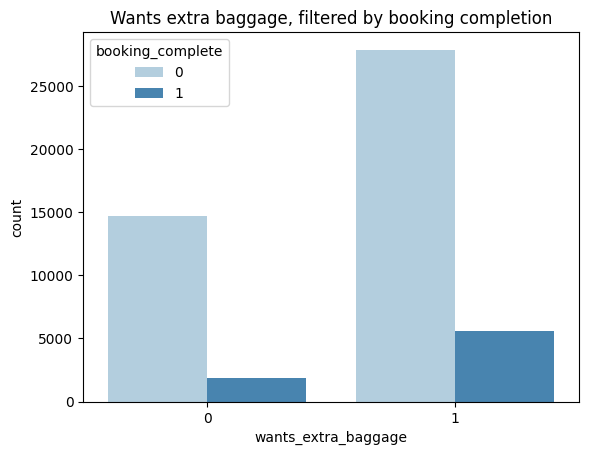

In [31]:
sns.countplot(data = df, x = 'wants_extra_baggage', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                                    'Wants extra baggage, filtered by booking completion')

[Text(0.5, 1.0, 'Wants preferred seat, filtered by booking completion')]

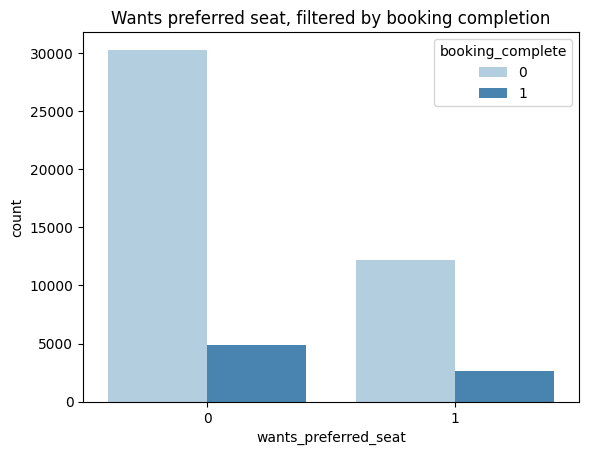

In [32]:
sns.countplot(data = df, x = 'wants_preferred_seat', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                                    'Wants preferred seat, filtered by booking completion')

[Text(0.5, 1.0, 'Wants in flight meals, filtered by booking completion')]

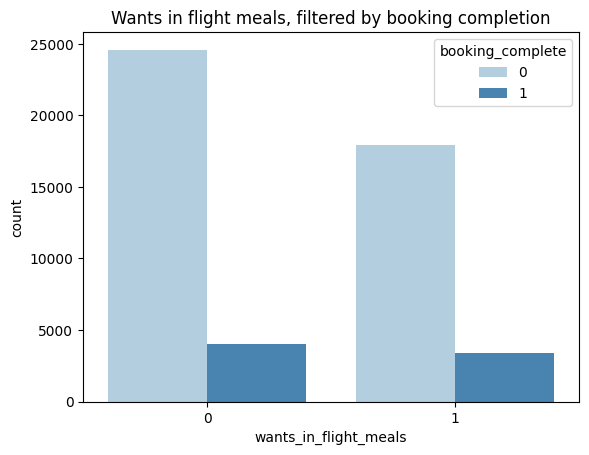

In [33]:
sns.countplot(data = df, x = 'wants_in_flight_meals', hue = 'booking_complete', palette = 'Blues').set(title = 
                                                                                    'Wants in flight meals, filtered by booking completion')

[Text(0.5, 1.0, 'Distribution of flight duration')]

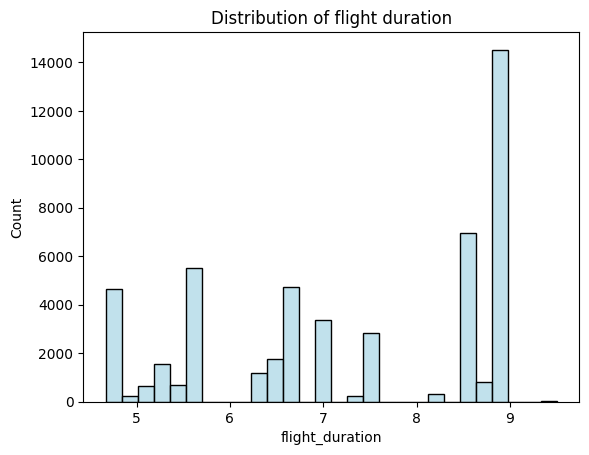

In [34]:
sns.histplot(data = df, x = 'flight_duration', color = 'lightblue').set(title = 'Distribution of flight duration')

### 2.2 Feature Engineering

#### 2.2.1 Route Distance

In [37]:
#Splitting the route column into a column for origin airport and one for destination airport.
origins = []
destinations = []
for route in df['route']:
    origins.append(route[0:3])
    destinations.append(route[3:])
df['origin'] = origins
df['destination'] = destinations

In [38]:
airports = airportsdata.load('IATA') 

In [39]:
#Creating a list with the coordinates of the origin airport
origin_lat = []
origin_lon = []
for row in df['origin']:
    try:
        origin_lat.append(airports[row]['lat'])
        origin_lon.append(airports[row]['lon'])
    except KeyError:
        if row == 'SXF':
            origin_lat.append(52.385441)
            origin_lon.append(13.521615)
        elif row == 'SZY':
            origin_lat.append(52.43611)
            origin_lon.append(20.938334)
        elif row == 'WMI':
            origin_lat.append(52.449265)
            origin_lon.append(20.651237)
        else:
            print(f'{row} is missing')
              
origin_coord = list(zip(origin_lat, origin_lon))
len(origin_coord)

50000

In [40]:
#Creating a list with the coordinates of the destination airport
destination_lat = []
destination_lon = []
for row in df['destination']:
    try:
        destination_lat.append(airports[row]['lat'])
        destination_lon.append(airports[row]['lon'])
    except KeyError:
        if row == 'SXF':
            destination_lat.append(52.385441)
            destination_lon.append(13.521615)
        elif row == 'SZY':
            destination_lat.append(52.43611)
            destination_lon.append(20.938334)
        elif row == 'WMI':
            destination_lat.append(52.449265)
            destination_lon.append(20.651237)
        else:
            print(f'{row} is missing')
            
destination_coord = list(zip(destination_lat, destination_lon))
len(destination_coord)

50000

In [41]:
#Creating a column with the distance between the origin and destination airports
distances = []
for index in range(len(origin_coord)):
    distances.append(geopy.distance.geodesic(origin_coord[index], destination_coord[index]).km)
        
df['airports_distance'] = distances

[Text(0.5, 1.0, 'Distribution of route distance in km')]

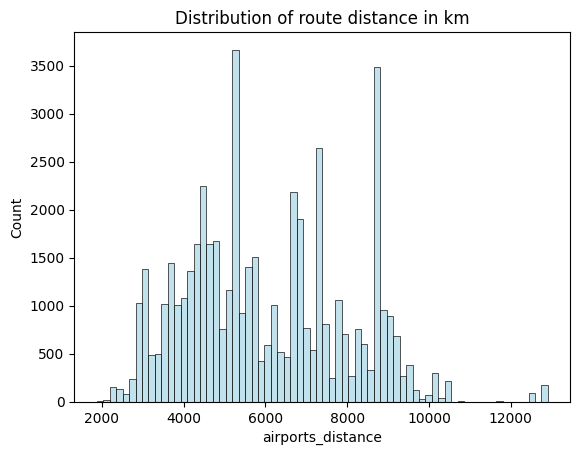

In [42]:
sns.histplot(data = df, x = 'airports_distance', color = 'lightblue').set(title = 'Distribution of route distance in km')

#### 2.2.2 Day/Hour transformations  
It is important to transform the time variables (day and hour) to reflect their cyclical nature. In this case we will use a sine/cosine transformation to uniquely identify every value of the day of week and hour variables.

In [43]:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [44]:
df = df.replace({'flight_day': {'Mon' : 0, 'Tue' : 1, 'Wed' : 2, 'Thu' : 3, 'Fri' : 4, 'Sat' : 5, 'Sun' : 6}}) 
df['flight_day'].unique()

array([5, 2, 3, 0, 6, 1, 4], dtype=int64)

In [45]:
df['flight_hour_cos'] = np.cos(2*np.pi*df['flight_hour']/24)
df['flight_hour_sin'] = np.sin(2*np.pi*df['flight_hour']/24)

df['flight_day_cos'] = np.cos(2*np.pi*df['flight_day']/7)
df['flight_day_sin'] = np.sin(2*np.pi*df['flight_day']/7)

### 2.3 Train_validation_test split

The first step before dealing with outliers or any further transformations or modeling is splitting the data into training, validation, and testing sets. We make sure to add the argument stratify in order to keep the same percentages of the two categories of the target variable in all the subsets.

In [47]:
df_train, df_test =  train_test_split(df, test_size=0.3,random_state=0, stratify = df['booking_complete'])

In [48]:
df_validation, df_test =  train_test_split(df_test, test_size=0.5,random_state=0, stratify = df_test['booking_complete'])

In [49]:
df['booking_complete'].value_counts(normalize=True) * 100

0    85.044
1    14.956
Name: booking_complete, dtype: float64

In [50]:
df_validation['booking_complete'].value_counts(normalize=True) * 100

0    85.04
1    14.96
Name: booking_complete, dtype: float64

In [51]:
df_test['booking_complete'].value_counts(normalize=True) * 100

0    85.053333
1    14.946667
Name: booking_complete, dtype: float64

### 2.4 Dealing with outliers

Now, we will have a look again at some of the outliers we identified in the previous visualizations and remove them from the training data.

#### num_passengers

[Text(0.5, 1.0, 'Distribution of number of passengers')]

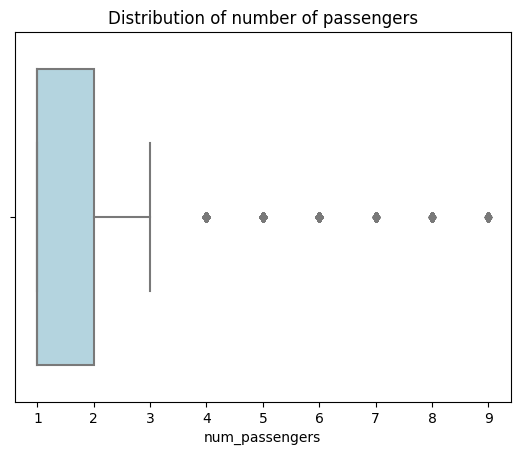

In [54]:
sns.boxplot(data = df_train, x = 'num_passengers', color = 'lightblue').set(title= 'Distribution of number of passengers')

In [55]:
df_train = df_train[df_train.num_passengers < 4]
df_train = df_train.reset_index(drop=True)

[Text(0.5, 1.0, 'Distribution of number of passengers')]

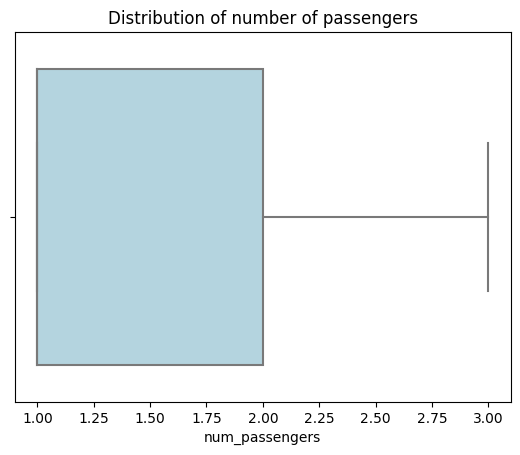

In [56]:
sns.boxplot(data = df_train, x = 'num_passengers', color = 'lightblue').set(title= 'Distribution of number of passengers')

#### length_of_stay

[Text(0.5, 1.0, 'Distribution of length of stay')]

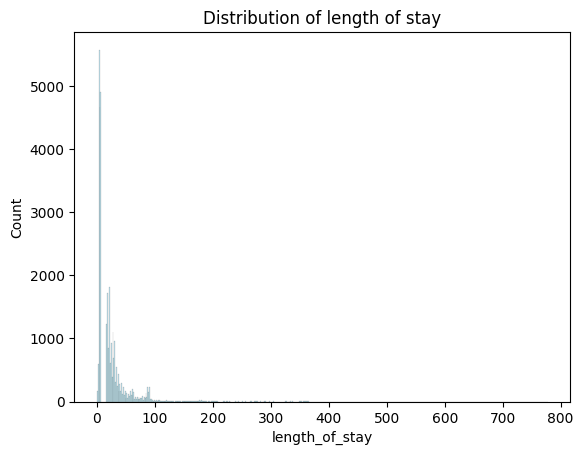

In [57]:
sns.histplot(data = df_train, x = 'length_of_stay', color = 'lightblue').set(title = 'Distribution of length of stay')

[Text(0.5, 1.0, 'Distribution of length of stay')]

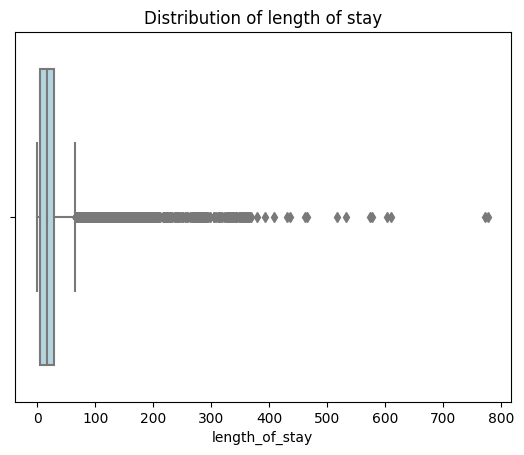

In [58]:
sns.boxplot(data = df_train, x = 'length_of_stay', color = 'lightblue').set(title= 'Distribution of length of stay')

In [59]:
upper_quartile = np.percentile(df_train['length_of_stay'], 75)
lower_quartile = np.percentile(df_train['length_of_stay'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df_train['length_of_stay'][df_train['length_of_stay']<=upper_quartile+1.5*iqr].max()
upper_whisker

65

In [60]:
df_train = df_train[df_train.length_of_stay <= upper_whisker]
df_train = df_train.reset_index(drop=True)

In [61]:
len(df_train)

30486

[Text(0.5, 1.0, 'Distribution of length of stay')]

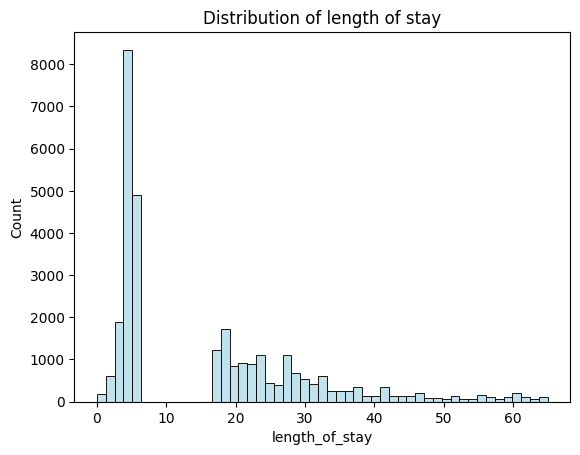

In [62]:
sns.histplot(data = df_train, x = 'length_of_stay', color = 'lightblue').set(title = 'Distribution of length of stay')

### 2.5 Random Undersampling

Because of the class imbalance, we need to resample the training dataset. In this case, we will randomly undersample the majority class (0)

In [64]:
X_train = df_train.drop('booking_complete', axis=1)
y_train = df_train.booking_complete

X_validation = df_validation.drop('booking_complete', axis=1)
y_validation = df_validation.booking_complete

X_test = df_test.drop('booking_complete', axis=1)
y_test = df_test.booking_complete

In [65]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

### 2.6 One-Hot Encoding and standardization

We will create three versions of the features:  
- One hot encoded + standardized for logistic regression with regularization: X_train_std, X_validation_std, X_test_std    
- One hot encoded for decision trees/random forests: X_train_ohe, X_validation_ohe, X_test_ohe  
- With categorical features for catboost: X_train_cat, X_validation_cat, X_test_cat

In [83]:
whole=pd.concat([X_train_rus, X_validation, X_test],axis=0)
unique_trip_type = whole.trip_type.unique()
unique_sales_channel = whole.sales_channel.unique()

In [84]:
X_train_ohe = pd.get_dummies(data=X_train_rus, columns = ['trip_type', 'sales_channel'])
X_validation_ohe = pd.get_dummies(data=X_validation, columns = ['trip_type', 'sales_channel'])
X_test_ohe = pd.get_dummies(data=X_test, columns =['trip_type', 'sales_channel'])

In [85]:
X_train_ohe.drop(columns = ['trip_type_CircleTrip', 'sales_channel_Internet'], inplace = True)
X_validation_ohe.drop(columns = ['trip_type_CircleTrip', 'sales_channel_Internet'], inplace = True)
X_test_ohe.drop(columns = ['trip_type_CircleTrip', 'sales_channel_Internet'], inplace = True)

In [86]:
X_train_ohe.drop(columns = ['route', 'booking_origin', 'flight_hour', 'flight_day', 'origin', 'destination'], inplace = True)
X_validation_ohe.drop(columns = ['route', 'booking_origin', 'flight_hour', 'flight_day', 'origin', 'destination'], inplace = True)
X_test_ohe.drop(columns = ['route', 'booking_origin', 'flight_hour', 'flight_day', 'origin', 'destination'], inplace = True)

In [87]:
X_validation_ohe = X_validation_ohe.loc[:, list(X_train_ohe.columns)]
X_test_ohe = X_test_ohe.loc[:, list(X_train_ohe.columns)]

In [88]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_ohe)
X_validation_std = scaler.transform(X_validation_ohe)
X_test_std = scaler.transform(X_test_ohe)

In [89]:
X_train_cat = X_train_rus.drop(columns = ['flight_hour_cos', 'flight_hour_sin', 'flight_day_cos', 'flight_day_sin','origin', 'destination'])
X_validation_cat = X_validation.drop(columns = ['flight_hour_cos', 'flight_hour_sin', 'flight_day_cos', 'flight_day_sin','origin', 'destination'])
X_test_cat = X_test.drop(columns = ['flight_hour_cos', 'flight_hour_sin', 'flight_day_cos', 'flight_day_sin','origin', 'destination'])

## 3. Modeling

We will focus on the recall as our evaluation metric, because the goal will be to detect as many positives as possible.

In [90]:
def Metrics(y_true,y_pred,data='train'):
    print('The metrics for the {} dataset are:'.format(data))
    print('Precision: %.3f' % precision_score(y_true, y_pred))
    print('Recall: %.3f' % recall_score(y_true, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print('F1 Score: %.3f' % f1_score(y_true, y_pred))
    print('------')

### 3.1 Logistic Regression

In [92]:
logistic_model = LogisticRegression()
params = {'C': [0.1, 0.5, 1, 2, 5, 10, 100], 'tol': [0.0001, 0.00001, 0.0005, 0.001, 0.0000001, 0.02, 0.01]}
rand1 = RandomizedSearchCV(logistic_model, params, scoring = 'recall')
rand1.fit(X_train_std, y_train_rus)

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.1, 0.5, 1, 2, 5, 10, 100],
                                        'tol': [0.0001, 1e-05, 0.0005, 0.001,
                                                1e-07, 0.02, 0.01]},
                   scoring='recall')

In [93]:
rand1.best_params_

{'tol': 0.0001, 'C': 1}

In [95]:
preds_train = rand1.predict(X_train_std)
preds_validation = rand1.predict(X_validation_std)
Metrics(y_train_rus,preds_train,data='train')
Metrics(y_validation,preds_validation,data='validation')

The metrics for the train dataset are:
Precision: 0.626
Recall: 0.665
Accuracy: 0.633
F1 Score: 0.645
------
The metrics for the validation dataset are:
Precision: 0.222
Recall: 0.622
Accuracy: 0.617
F1 Score: 0.327
------


### 3.2 Decision Tree

In [102]:
decision_tree=DecisionTreeClassifier()
params = {'max_depth' : [2,5,7,8,9,10,12, None], 'criterion': ['gini', 'entropy', 'log_loss']}
rand2 = RandomizedSearchCV(decision_tree, params, scoring = 'recall')
rand2.fit(X_train_ohe,y_train_rus)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 7, 8, 9, 10, 12,
                                                      None]},
                   scoring='recall')

In [103]:
rand2.best_params_

{'max_depth': 2, 'criterion': 'entropy'}

In [104]:
preds_train = rand2.predict(X_train_ohe)
preds_validation = rand2.predict(X_validation_ohe)
Metrics(y_train_rus,preds_train,data='train')
Metrics(y_validation,preds_validation,data='validation')

The metrics for the train dataset are:
Precision: 0.582
Recall: 0.791
Accuracy: 0.612
F1 Score: 0.671
------
The metrics for the validation dataset are:
Precision: 0.191
Recall: 0.734
Accuracy: 0.495
F1 Score: 0.303
------


### 3.3 Random Forest

In [105]:
random_forest = RandomForestClassifier()
params = {'n_estimators' : [100,150,200,230,250,270,300,350,400,450,500,1000], 'max_depth': [2,3,4,5,6,7,8,9,10,11,12], 
          'criterion':['gini', 'entropy', 'log_loss']}
rand3 = RandomizedSearchCV(random_forest, params, scoring = 'recall')
rand3.fit(X_train_ohe, y_train_rus)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12],
                                        'n_estimators': [100, 150, 200, 230,
                                                         250, 270, 300, 350,
                                                         400, 450, 500, 1000]},
                   scoring='recall')

In [106]:
rand3.best_params_

{'n_estimators': 500, 'max_depth': 10, 'criterion': 'gini'}

In [107]:
preds_train = rand3.predict(X_train_ohe)
preds_validation = rand3.predict(X_validation_ohe)
Metrics(y_train_rus,preds_train,data='train')
Metrics(y_validation,preds_validation,data='validation')

The metrics for the train dataset are:
Precision: 0.787
Recall: 0.795
Accuracy: 0.790
F1 Score: 0.791
------
The metrics for the validation dataset are:
Precision: 0.246
Recall: 0.639
Accuracy: 0.652
F1 Score: 0.355
------


### 3.4 Catboost

In [112]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(verbose = False, task_type = "GPU")
parameters = {'depth': [3,4,5,6,7,8,9,10], 'iterations':[50,100,200,250,270,330,400,500], 'learning_rate':[0.01,0.02,0.03,0.04], 
              'reg_lambda':[0.0001,0.001,0.005,0.01,0.05,0.1]}

rand4 = RandomizedSearchCV(cat_model, parameters, n_iter = 10, cv = 5, scoring = 'recall', random_state = 0)
rand4.fit(X_train_cat, y_train_rus, cat_features= np.where(X_train_cat.dtypes == 'object')[0])

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000020B219CC430>,
                   param_distributions={'depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [50, 100, 200, 250, 270,
                                                       330, 400, 500],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04],
                                        'reg_lambda': [0.0001, 0.001, 0.005,
                                                       0.01, 0.05, 0.1]},
                   random_state=0, scoring='recall')

In [113]:
rand4.best_params_

{'reg_lambda': 0.001, 'learning_rate': 0.01, 'iterations': 250, 'depth': 8}

In [114]:
preds_train = rand4.predict(X_train_cat)
preds_validation = rand4.predict(X_validation_cat)
Metrics(y_train_rus,preds_train,data='train')
Metrics(y_validation,preds_validation,data='validation')

The metrics for the train dataset are:
Precision: 0.749
Recall: 0.830
Accuracy: 0.776
F1 Score: 0.788
------
The metrics for the validation dataset are:
Precision: 0.293
Recall: 0.778
Accuracy: 0.686
F1 Score: 0.426
------


## 4. Model Evaluation (CatBoost)

Based on the validation recall, the final model we keep is CatBoost. The recall is still pretty low, which probably means that we don't have enough data about the customers to accurately predict their buying behaviour. Nonetheless, this model can still be helpful to determine which features play the biggest role in the classification.  
First, let's look at the test performance.

In [115]:
preds_train = rand4.predict(X_train_cat)
preds_validation = rand4.predict(X_validation_cat)
Metrics(y_train_rus,preds_train,data='train')
Metrics(y_validation,preds_validation,data='validation')
preds_test = rand4.predict(X_test_cat)
Metrics(y_test,preds_test,data='test')

The metrics for the train dataset are:
Precision: 0.749
Recall: 0.830
Accuracy: 0.776
F1 Score: 0.788
------
The metrics for the validation dataset are:
Precision: 0.293
Recall: 0.778
Accuracy: 0.686
F1 Score: 0.426
------
The metrics for the test dataset are:
Precision: 0.297
Recall: 0.780
Accuracy: 0.691
F1 Score: 0.430
------


**Confusion Matrix of the test set**

In [117]:
def plot_cm(test_y,predicted):
    
    cm=confusion_matrix(y_true=test_y,y_pred=predicted)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',cbar=False);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.show()  

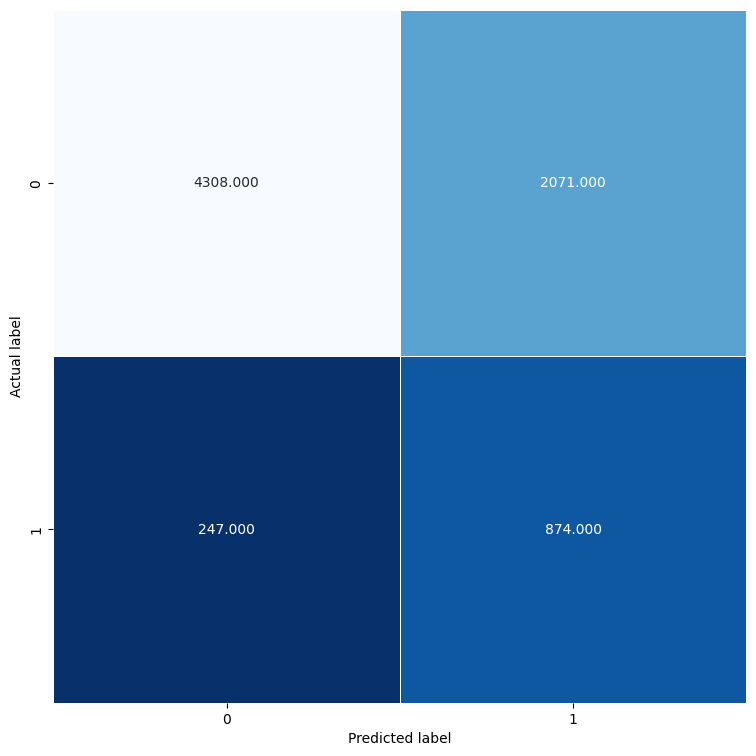

In [118]:
plot_cm(test_y=y_test,predicted=preds_test)

**Feature Importance**

In [119]:
rand4.best_estimator_.feature_importances_

array([ 1.12620194,  7.35511477,  1.82641497,  8.38460926,  7.68898494,
        6.53640495,  3.18772222, 14.3734772 , 22.13547889,  5.9481378 ,
        4.30983169,  3.78938037,  4.20419086,  9.13405014])

In [121]:
feat_df = pd.DataFrame({'Feature':X_train_cat.columns,'Importance':rand4.best_estimator_.feature_importances_}).sort_values(by=['Importance'],ascending=False)
feat_df

,Feature,Importance
8,booking_origin,22.135479
7,route,14.373477
13,airports_distance,9.134050
3,purchase_lead,8.384609
4,length_of_stay,7.688985
1,sales_channel,7.355115
5,flight_hour,6.536405
9,wants_extra_baggage,5.948138
10,wants_preferred_seat,4.309832
12,flight_duration,4.204191


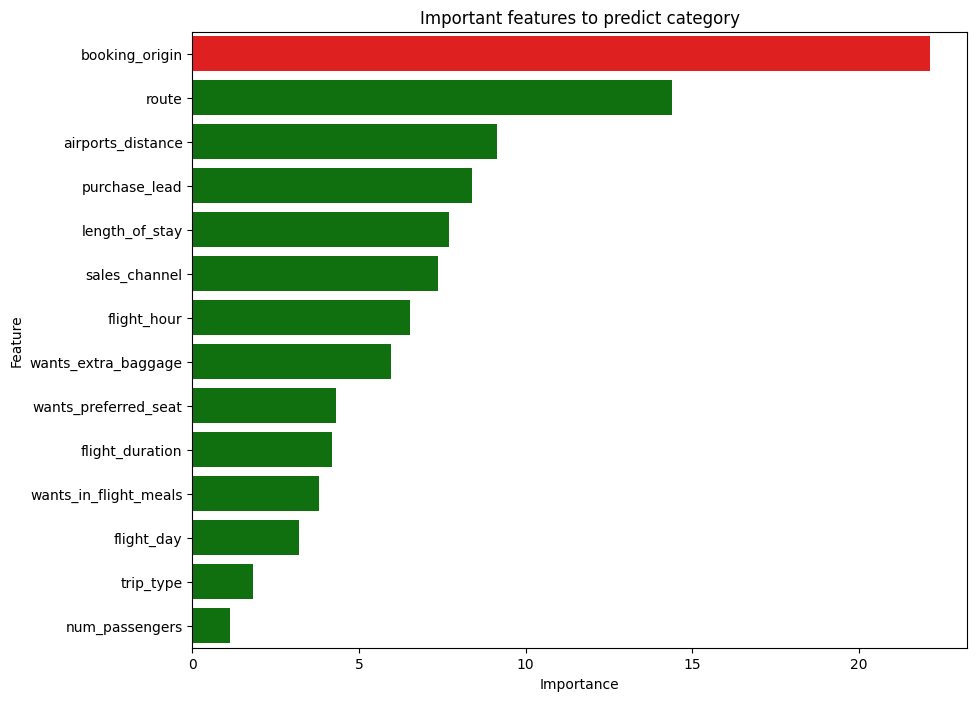

In [122]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict category')
plt.show()